In [1]:
from google.colab import files

# Prompt user to upload required files
uploaded = files.upload()

Saving mock_1-1-MOODSTUDY_2024-08-21_prv.csv to mock_1-1-MOODSTUDY_2024-08-21_prv (1).csv
Saving updated_1-1-MOODSTUDY_2024-08-29_prv.csv to updated_1-1-MOODSTUDY_2024-08-29_prv (1).csv
Saving updated_1-1-MOODSTUDY_2024-09-21_prv.csv to updated_1-1-MOODSTUDY_2024-09-21_prv (1).csv
Saving updated_968046_FrontView_Labels.xlsx to updated_968046_FrontView_Labels (1).xlsx
Saving updated_968048_FrontView_Labels.xlsx to updated_968048_FrontView_Labels (1).xlsx
Saving updated_968050_FrontView_Labels.xlsx to updated_968050_FrontView_Labels (1).xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time

from datetime import datetime, timedelta

In [3]:
# Correct session date for each participant
session_dates = {
    'participant1': '2024-08-21',
    'participant2': '2024-08-29',
    'participant3': '2024-09-21'
}


In [4]:
# Participant label and HRV mapping
participants = {
    'participant1': ('updated_968050_FrontView_Labels.xlsx', 'mock_1-1-MOODSTUDY_2024-08-21_prv.csv'),
    'participant2': ('updated_968046_FrontView_Labels.xlsx', 'updated_1-1-MOODSTUDY_2024-08-29_prv.csv'),
    'participant3': ('updated_968048_FrontView_Labels.xlsx', 'updated_1-1-MOODSTUDY_2024-09-21_prv.csv')
}


In [5]:
padding = timedelta(minutes=2)

def extract_segment(df, start, end, clip_name):
    padded_start = start - padding
    padded_end = end + padding
    segment = df[(df['timestamp_iso'] >= padded_start) & (df['timestamp_iso'] <= padded_end)].copy()
    segment['clip'] = clip_name
    return segment


In [6]:
all_segments = []

for pid, (label_file, hrv_file) in participants.items():
    print(f"\n🔍 Processing {pid}")

    try:
        labels_df = pd.read_excel(label_file)
        hrv_df = pd.read_csv(hrv_file, parse_dates=['timestamp_iso'])
        print(f"✅ Loaded: {label_file}, {hrv_file}")
    except Exception as e:
        print(f"❌ Failed to load {pid}: {e}")
        continue

    # Timestamp conversion
    labels_df['start_time'] = pd.to_datetime(session_dates[pid]) + pd.to_timedelta('00:' + labels_df['music_starttime'])
    labels_df['end_time'] = pd.to_datetime(session_dates[pid]) + pd.to_timedelta('00:' + labels_df['music_endtime'])

    labels_df['start_time'] = labels_df['start_time'].dt.tz_localize('UTC')
    labels_df['end_time'] = labels_df['end_time'].dt.tz_localize('UTC')
    labels_df['type'] = labels_df['File_name'].apply(lambda x: 'Audio' if 'Audio' in x else 'Video')

    extracted_count = 0
    for _, row in labels_df.iterrows():
        segment = extract_segment(hrv_df, row['start_time'], row['end_time'], row['File_name'])
        if not segment.empty:
            segment['participant'] = pid
            segment['Q1'] = row.get('Q1', np.nan)
            segment['Q2'] = row.get('Q2', np.nan)
            segment['Q3'] = row.get('Q3', np.nan)
            segment['Q4'] = row.get('Q4', np.nan)
            segment['Emotion'] = row.get('Emotion', np.nan)
            segment['type'] = row['type']
            all_segments.append(segment)
            extracted_count += len(segment)

# Combine all participants' segments
combined_df = pd.concat(all_segments, ignore_index=True)



🔍 Processing participant1
✅ Loaded: updated_968050_FrontView_Labels.xlsx, mock_1-1-MOODSTUDY_2024-08-21_prv.csv

🔍 Processing participant2
✅ Loaded: updated_968046_FrontView_Labels.xlsx, updated_1-1-MOODSTUDY_2024-08-29_prv.csv

🔍 Processing participant3
✅ Loaded: updated_968048_FrontView_Labels.xlsx, updated_1-1-MOODSTUDY_2024-09-21_prv.csv


In [7]:

# Map 'Emotion' to new 'Emotion_Label'
def map_emotion_label(emotion):
    if isinstance(emotion, str):
        emotion = emotion.lower().strip()
        if emotion in ['relaxed', 'happy']:
            return 'positive'
        elif emotion in ['angry', 'sad']:
            return 'negative'
    return 'neutral'

combined_df = pd.concat(all_segments, ignore_index=True)
combined_df['Emotion_Label'] = combined_df['Emotion'].apply(map_emotion_label)

# --- 5. Prepare Final Dataset for Modeling ---

# Aggregate Mean HRV across each clip per participant
final_df = combined_df.groupby(['participant', 'type', 'Q1', 'Q2', 'Q3', 'Q4', 'Emotion']).agg(
    mean_hrv=('prv_rmssd_ms', 'mean')
).reset_index()

# Map emotion labels
emotion_labels = {0: 'Relaxed', 1: 'Happy', 2: 'Sad', 3: 'Neutral', 4: 'Angry'}
# Merge Emotion_Label from combined_df
final_df = pd.merge(
    final_df,
    combined_df[['participant', 'Emotion', 'Emotion_Label']].drop_duplicates(),
    on=['participant', 'Emotion'],
    how='left'
)

final_df['emotion_name'] = final_df['Emotion'].map(emotion_labels)

# Separate audio and video
audio_data = final_df[final_df['type'] == 'Audio']
video_data = final_df[final_df['type'] == 'Video']



In [8]:
print("\n🔍 Checking shapes:")
print(f"audio_data shape: {audio_data.shape}")
print(f"video_data shape: {video_data.shape}")



🔍 Checking shapes:
audio_data shape: (36, 10)
video_data shape: (35, 10)


In [9]:
print("\n🔍 Audio Data - Missing Summary:")
print(audio_data[['mean_hrv', 'Emotion', 'Emotion_Label']].isnull().sum())

print("\n🔍 Video Data - Missing Summary:")
print(video_data[['mean_hrv', 'Emotion', 'Emotion_Label']].isnull().sum())

print("\n🔍 Audio Data - Sample Rows:")
print(audio_data[['mean_hrv', 'Emotion', 'Emotion_Label']].head())

print("\n🔍 Video Data - Sample Rows:")
print(video_data[['mean_hrv', 'Emotion', 'Emotion_Label']].head())




🔍 Audio Data - Missing Summary:
mean_hrv         0
Emotion          0
Emotion_Label    0
dtype: int64

🔍 Video Data - Missing Summary:
mean_hrv         0
Emotion          0
Emotion_Label    0
dtype: int64

🔍 Audio Data - Sample Rows:
   mean_hrv  Emotion Emotion_Label
0   0.65575  Relaxed      positive
1   0.63525    Angry      negative
2   0.65400  Neutral       neutral
3   1.00925  Neutral       neutral
4   1.10800  Relaxed      positive

🔍 Video Data - Sample Rows:
    mean_hrv  Emotion Emotion_Label
12   0.95980  Relaxed      positive
13   0.90580  Neutral       neutral
14   0.82625  Neutral       neutral
15   1.16650      Sad      negative
16   0.96925  Relaxed      positive



📊 Plotting Audio HRV Distribution


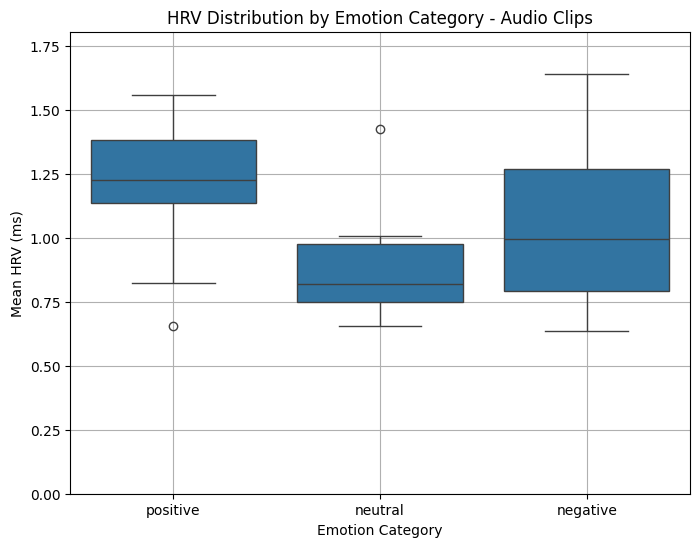


📊 Plotting Video HRV Distribution


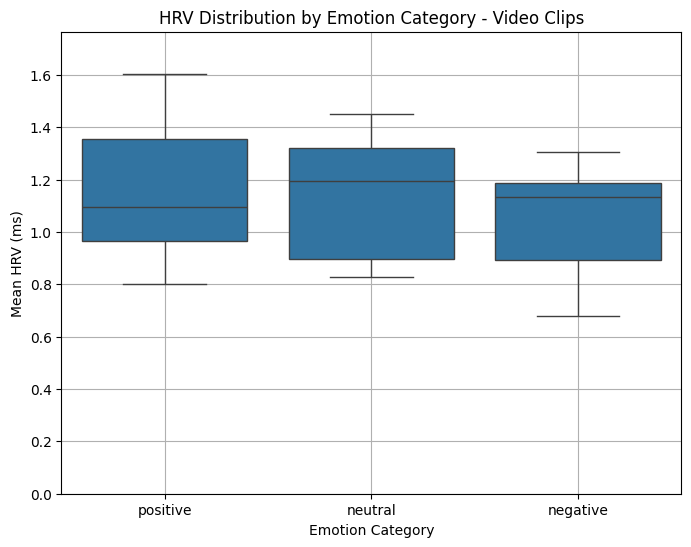

In [10]:
def plot_hrv_distribution(df, title):
    # Drop rows with missing HRV or Emotion_Label
    df = df.dropna(subset=['mean_hrv', 'Emotion_Label'])

    if df.empty:
        print(f"⚠️ No valid data available for {title}. Skipping plot.")
        return

    plt.figure(figsize=(8,6))
    sns.boxplot(x='Emotion_Label', y='mean_hrv', data=df, order=['positive', 'neutral', 'negative'])
    plt.ylim(0, df['mean_hrv'].max() * 1.1)
    plt.title(f'HRV Distribution by Emotion Category - {title}')
    plt.xlabel('Emotion Category')
    plt.ylabel('Mean HRV (ms)')
    plt.grid(True)
    plt.show()




print("\n📊 Plotting Audio HRV Distribution")
plot_hrv_distribution(audio_data, 'Audio Clips')

print("\n📊 Plotting Video HRV Distribution")
plot_hrv_distribution(video_data, 'Video Clips')

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Features to use
features = ['mean_hrv', 'Q1', 'Q2', 'Q3', 'Q4']

# Prepare Audio dataset
X_audio = audio_data[features]
y_audio = audio_data['Emotion_Label']

# Prepare Video dataset
X_video = video_data[features]
y_video = video_data['Emotion_Label']

# Prepare Combined dataset
X_combined = pd.concat([audio_data, video_data])
X_combined_features = X_combined[features]
y_combined = X_combined['Emotion_Label']

def train_random_forest(X, y, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔵 {title} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return model

# Train models
rf_audio = train_random_forest(X_audio, y_audio, "Audio Clips Model")
rf_video = train_random_forest(X_video, y_video, "Video Clips Model")
rf_combined = train_random_forest(X_combined_features, y_combined, "Combined Audio+Video Model")



🔵 Audio Clips Model Accuracy: 0.5000
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
    positive       0.57      0.80      0.67         5

    accuracy                           0.50         8
   macro avg       0.29      0.40      0.33         8
weighted avg       0.36      0.50      0.42         8


🔵 Video Clips Model Accuracy: 0.4286
              precision    recall  f1-score   support

    negative       0.33      0.33      0.33         3
     neutral       0.00      0.00      0.00         0
    positive       0.67      0.50      0.57         4

    accuracy                           0.43         7
   macro avg       0.33      0.28      0.30         7
weighted avg       0.52      0.43      0.47         7


🔵 Combined Audio+Video Model Accuracy: 0.4000
              precision    recall  f1-score   support

    negative       0.43      0.43      0.43         7
     neutral       0.00      0.00      0.00         3
    po

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p


🔵 Audio Clips Model Accuracy: 0.5000
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
    positive       0.57      0.80      0.67         5

    accuracy                           0.50         8
   macro avg       0.29      0.40      0.33         8
weighted avg       0.36      0.50      0.42         8


🔵 Video Clips Model Accuracy: 0.4286
              precision    recall  f1-score   support

    negative       0.33      0.33      0.33         3
     neutral       0.00      0.00      0.00         0
    positive       0.67      0.50      0.57         4

    accuracy                           0.43         7
   macro avg       0.33      0.28      0.30         7
weighted avg       0.52      0.43      0.47         7


🔵 Combined Audio+Video Model Accuracy: 0.4000
              precision    recall  f1-score   support

    negative       0.43      0.43      0.43         7
     neutral       0.00      0.00      0.00         3
    po

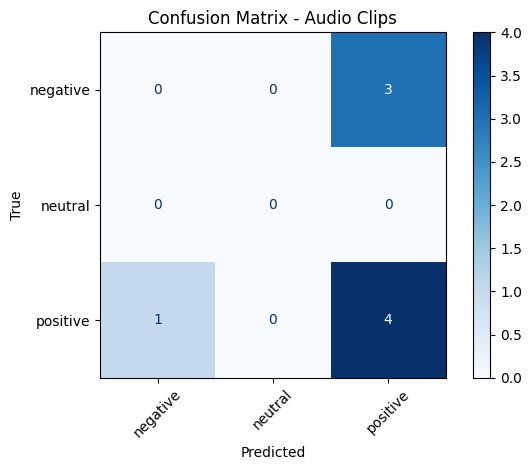

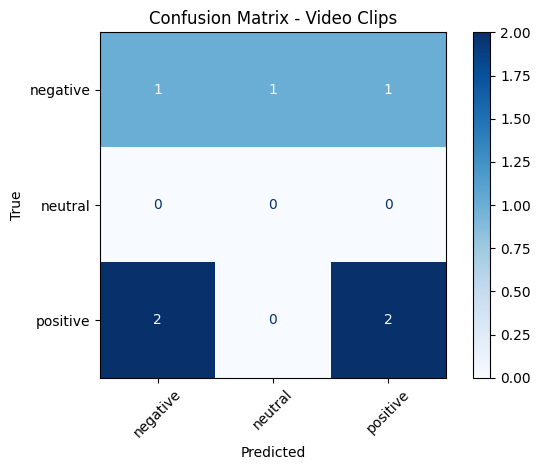

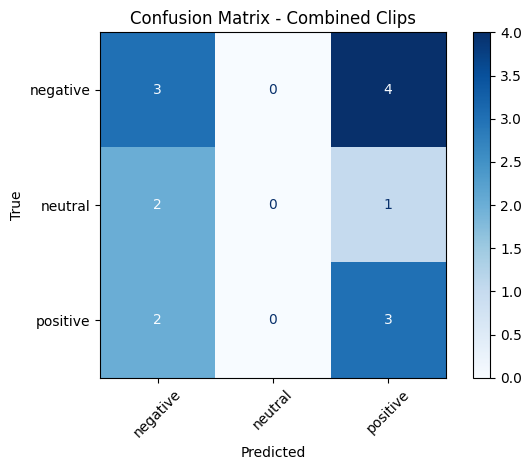

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot Confusion Matrix
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Train and return model, X_test, y_test
def train_random_forest(X, y, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔵 {title} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    return model, X_test, y_test

# Train Models
rf_audio_model, X_audio_test, y_audio_test = train_random_forest(X_audio, y_audio, "Audio Clips Model")
rf_video_model, X_video_test, y_video_test = train_random_forest(X_video, y_video, "Video Clips Model")
rf_combined_model, X_combined_test, y_combined_test = train_random_forest(X_combined_features, y_combined, "Combined Audio+Video Model")

# Plot Confusion Matrices
plot_confusion_matrix(rf_audio_model, X_audio_test, y_audio_test, "Confusion Matrix - Audio Clips")
plot_confusion_matrix(rf_video_model, X_video_test, y_video_test, "Confusion Matrix - Video Clips")
plot_confusion_matrix(rf_combined_model, X_combined_test, y_combined_test, "Confusion Matrix - Combined Clips")


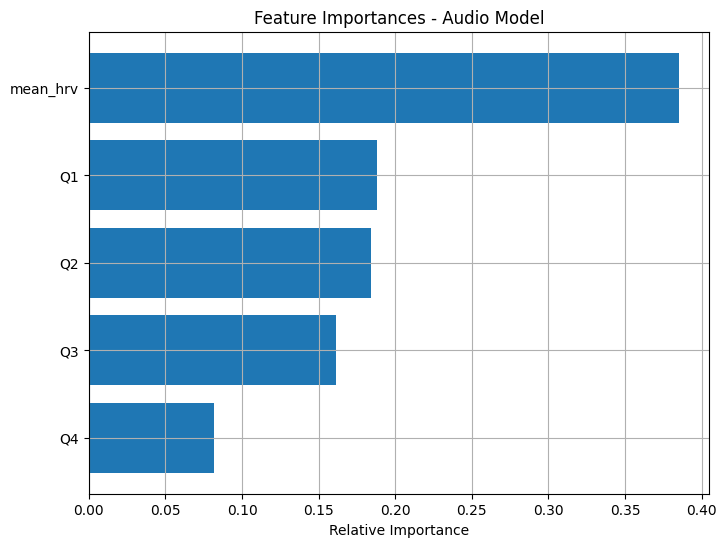

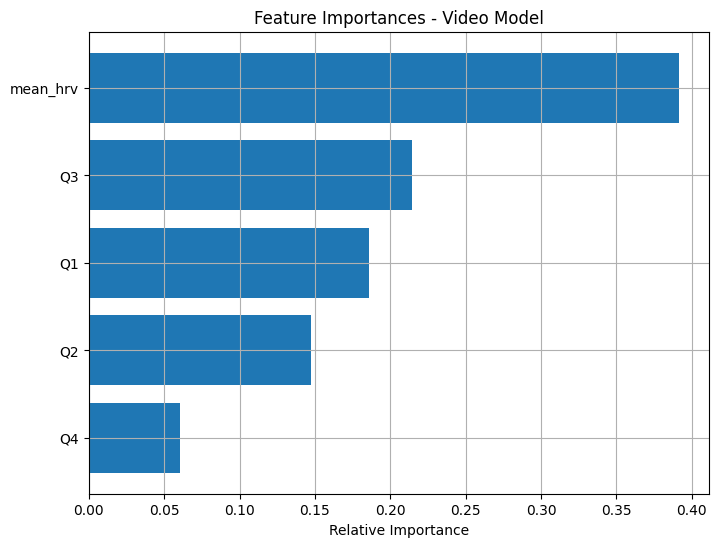

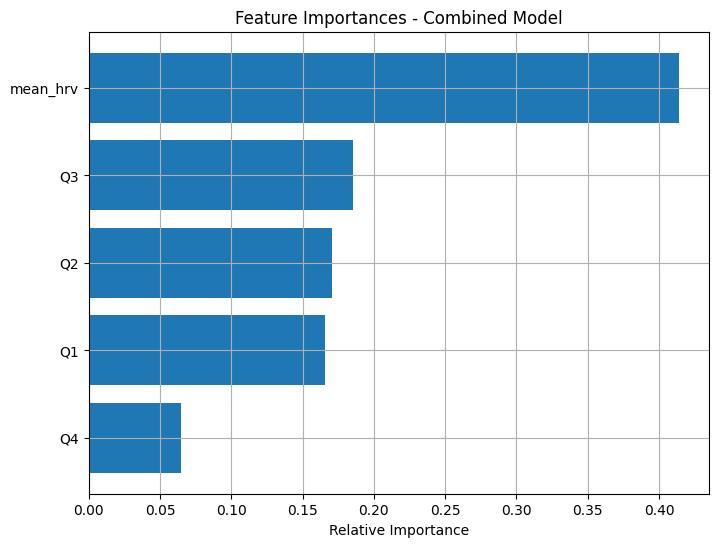

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(8,6))
    plt.title(f"Feature Importances - {title}")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.grid(True)
    plt.show()

# Run for all models
plot_feature_importance(rf_audio_model, ['mean_hrv', 'Q1', 'Q2', 'Q3', 'Q4'], "Audio Model")
plot_feature_importance(rf_video_model, ['mean_hrv', 'Q1', 'Q2', 'Q3', 'Q4'], "Video Model")
plot_feature_importance(rf_combined_model, ['mean_hrv', 'Q1', 'Q2', 'Q3', 'Q4'], "Combined Model")


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    labels = model.classes_
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


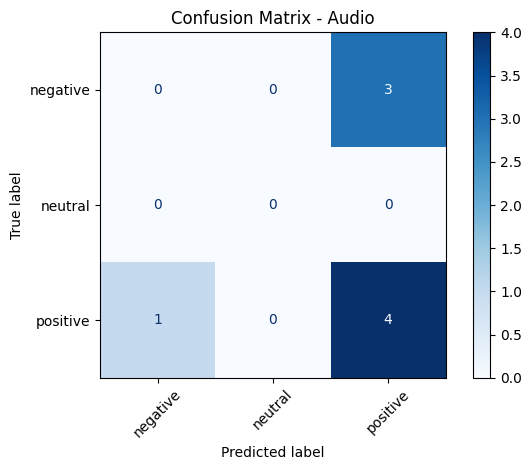

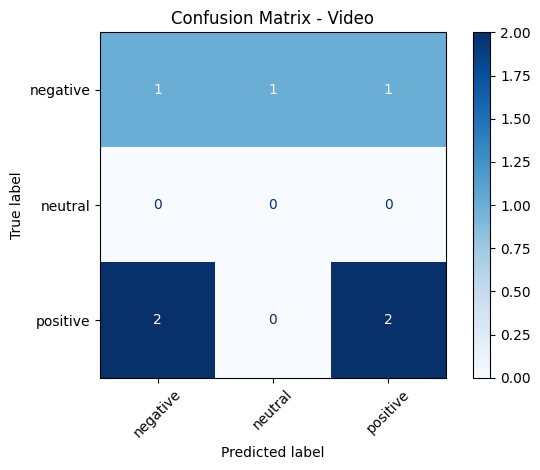

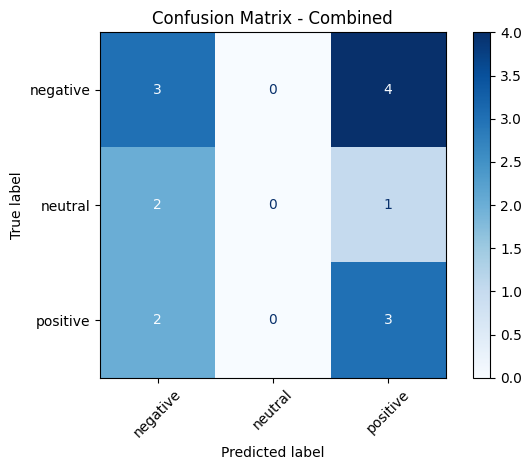

In [15]:
# Retrain and capture test sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def train_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    return clf, X_test, y_test

rf_audio_model, X_audio_test, y_audio_test = train_rf(X_audio, y_audio)
rf_video_model, X_video_test, y_video_test = train_rf(X_video, y_video)
rf_combined_model, X_combined_test, y_combined_test = train_rf(X_combined_features, y_combined)

# Plot confusion matrices
plot_confusion_matrix(rf_audio_model, X_audio_test, y_audio_test, "Confusion Matrix - Audio")
plot_confusion_matrix(rf_video_model, X_video_test, y_video_test, "Confusion Matrix - Video")
plot_confusion_matrix(rf_combined_model, X_combined_test, y_combined_test, "Confusion Matrix - Combined")


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop missing emotion label rows
ml_df = combined_df.dropna(subset=['Emotion_Label'])

# Encode categorical emotion label
ml_df['Emotion_Label_Code'] = ml_df['Emotion_Label'].astype('category').cat.codes

X = ml_df[['prv_rmssd_ms', 'Q1', 'Q2', 'Q3', 'Q4']]
y = ml_df['Emotion_Label_Code']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Decode labels for readable output
label_map = dict(enumerate(ml_df['Emotion_Label'].astype('category').cat.categories))
print("🎯 Emotion Classification Report:")
print(classification_report(y_test, y_pred, target_names=[label_map[i] for i in sorted(label_map)]))


🎯 Emotion Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.77      0.69        30
     neutral       0.82      0.60      0.69        15
    positive       0.80      0.73      0.76        33

    accuracy                           0.72        78
   macro avg       0.75      0.70      0.71        78
weighted avg       0.73      0.72      0.72        78

